# Import ONNX Models using DLPy

In this example, we will show how to import an ONNX ResNet50 model into SAS.  
This model was downloaded from the ONNX model zoo: https://github.com/onnx/models  
DLPy currently supports importing models with the following layer types: Convo, Pool, FC, Batchnorm, Residual, Concat  

### Import Libraries

In [1]:
import swat
from dlpy import Model
from dlpy.images import ImageTable
import onnx
import warnings
warnings.filterwarnings('ignore')

### Connect to CAS

In [2]:
s = swat.CAS(cashost, casport)

### Load the ONNX model

In [3]:
onnx_model = onnx.load_model('resnet50v1.onnx')

### Import Model

Specify the preprocessing (scale and offsets) used to train this model  

In [4]:
model1 = Model.from_onnx_model(s, 
                               onnx_model,
                               output_model_table='resnet50v1',
                               scale=0.0173611, 
                               offsets=[2.155, 2.027, 1.804])

NOTE: Successfully written weights file as /data/dlpy/resnet50v1_weights.onnxmodel.h5
NOTE: Model table is attached successfully!
NOTE: Model is named to "resnet50v1" according to the model name in the table.
NOTE: Successfully imported ONNX model.


In [5]:
model1.print_summary()

,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters
0,data,input,None,None,None,"(224, 224, 3)","(0, 0)"
1,resnetv17_conv0_fwd,convo,"(7, 7)",2,Identity,"(112, 112, 64)","(9408, 0)"
2,resnetv17_batchnorm0_fwd,batchnorm,None,None,Rectifier,"(112, 112, 64)","(0, 128)"
3,resnetv17_pool0_fwd,pool,"(3, 3)",2,Max,"(56, 56, 64)","(0, 0)"
4,resnetv17_stage1_conv3_fwd,convo,"(1, 1)",1,Identity,"(56, 56, 256)","(16384, 0)"
5,resnetv17_stage1_batchnorm3_fwd,batchnorm,None,None,Identity,"(56, 56, 256)","(0, 512)"
6,resnetv17_stage1_conv0_fwd,convo,"(1, 1)",1,Identity,"(56, 56, 64)","(4096, 64)"
7,resnetv17_stage1_batchnorm0_fwd,batchnorm,None,None,Rectifier,"(56, 56, 64)","(0, 128)"
8,resnetv17_stage1_conv1_fwd,convo,"(3, 3)",1,Identity,"(56, 56, 64)","(36864, 0)"
9,resnetv17_stage1_batchnorm1_fwd,batchnorm,None,None,Rectifier,"(56, 56, 64)","(0, 128)"


Load the Weights from the h5 File

In [6]:
# Specify labels=True to show the imagenet labels
model1.load_weights('/data/dlpy/resnet50v1_weights.onnxmodel.h5', labels=True)

NOTE: Cloud Analytic Services made the uploaded file available as table NEW_LABEL_TABLE_PN0ERF in caslib CASUSER(sas).
NOTE: The table NEW_LABEL_TABLE_PN0ERF has been created in caslib CASUSER(sas) from binary data uploaded to Cloud Analytic Services.
NOTE: Model weights attached successfully!


### Make Prediction Using Imported ResNet50

Load some test images

In [7]:
img = ImageTable.load_files(s, path='/data/dlpy/test_img')

In [8]:
img.resize(224)

NOTE: Due to data distribution, miniBatchSize has been limited to 1.
NOTE: Table TEMP_PLOT contains compressed images.
NOTE: Cloud Analytic Services dropped table TEMP_PLOT from caslib CASUSER(sas).


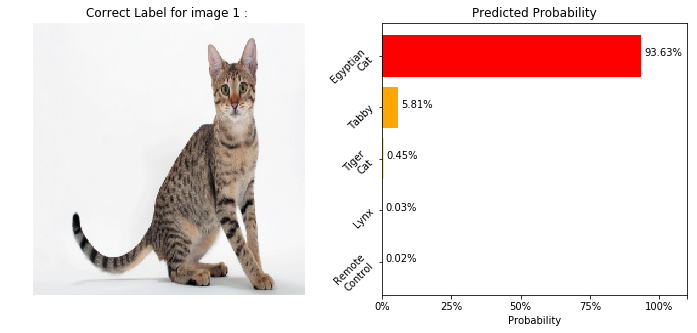

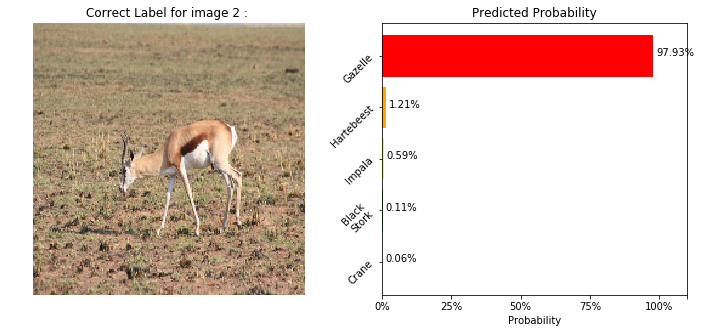

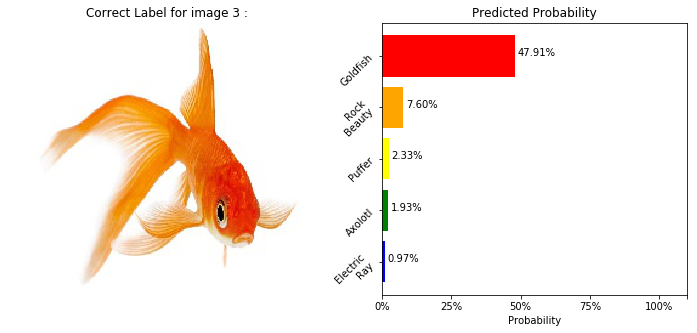

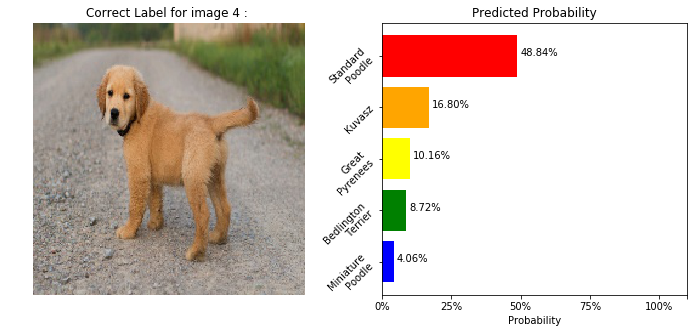

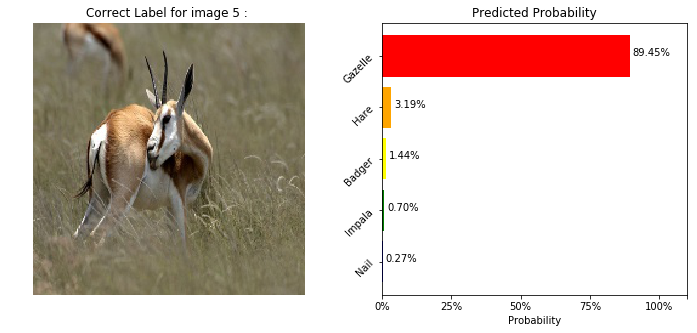

In [9]:
model1.evaluate(img)
model1.plot_evaluate_res()

In [10]:
s.endsession()

+ Elapsed: 0.000236s, mem: 0.21mb